In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression,LogisticRegression
import os,sys
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


In [2]:
def regreessBehavior(choiceB,qAs,qBs,seqAB=None):
    idx=(qAs!=0)&(qBs!=0)
    if seqAB is not None:
        X = np.vstack((np.log(qBs[idx]/qAs[idx]),seqAB[idx])).T
    else:
        X = np.log(qBs[idx]/qAs[idx]).reshape(-1,1)
    y = choiceB[idx]
    model = LogisticRegression()
    model.fit(X,y)
    return model
    # return model.intercept_[0], model.coef_[0]
def getIndPoint(dirPath):
    x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTest.npz')
    choiceB = np.array([0 if choiceAB[i]=='A' else 1 for i in range(len(trial_params))])
    model = regreessBehavior(choiceB,qAs,qBs)
    a0,(a1,) = model.intercept_[0], model.coef_[0]
    indPoint = np.exp(-a0/a1)
    return indPoint

def importAndPreprocess(dirPath,activityFileName):
    import os
    import sys

    
    with np.load(os.path.join(dirPath,activityFileName),allow_pickle=True) as f:
        x = f['x']
        trial_params = f['trial_params']
        model_output = f['model_output']
        model_state = f['model_state']
        mask = f.get('mask', None)
    
    if mask is None:
        temp = np.mean(model_output[:,300:,:],1)
    else: 
        temp = np.mean(mask * model_output,1)
    choiceLR = temp[:,1]>temp[:,0]
    choiceLR = choiceLR*2-1 # pos right high, neg left high
    
    choiceFrame = [trial_params[i]['choiceFrame'] for i in range(len(trial_params))]
    
    
    locAB = [(1 if trial_params[i]['locAB']=='AB' or trial_params[i]['locAB']=='12' else -1) for i in range(len(trial_params))]
    loc12 = locAB
    seqAB = [(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))]
    
    choiceAB = np.array([(choiceLR[i] * locAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i] * seqAB[i]) for i in range(len(trial_params)) ])  # pos B neg A
    choice12 = np.array([(choiceAB[i] * seqAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i]) for i in range(len(trial_params)) ])  # pos 2 neg 1
    choiceAB = np.array(['B' if choiceAB[i]>0 else 'A' for i in range(len(trial_params))])
    choice12 = np.array(['2' if choice12[i]>0 else '1' for i in range(len(trial_params))])
    
    qAs = np.array([trial_params[i]['qA'] for i in range(len(trial_params))])
    qBs = np.array([trial_params[i]['qB'] for i in range(len(trial_params))])
    seqAB = np.array([trial_params[i]['seqAB']for i in range(len(trial_params))])

    return x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB
def importTuningVariables(dirPath):
    x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTest.npz')
    indPoint=getIndPoint(dirPath)
    valueA = qAs*indPoint
    qBs = qBs*1.0
    valueB = qBs*1.0
    choiceAB = np.array([-1 if choiceAB[i]=='A' else 1 for i in range(len(trial_params))])
    choice12 = np.array([-1 if choice12[i]=='1' else 1 for i in range(len(trial_params))])
    seqAB = np.array([(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))])
    value1 = np.array([qAs[i]*indPoint if seqAB[i]>0 else qBs[i] for i in range(len(trial_params))])
    value2 = np.array([qAs[i]*indPoint if seqAB[i]<0 else qBs[i] for i in range(len(trial_params))])
    valueA_AB = qAs.copy()*indPoint
    valueA_BA = qAs.copy()*indPoint
    valueB_AB = qBs.copy()
    valueB_BA = qBs.copy()
    valueA_AB[seqAB<0] = 0
    valueA_BA[seqAB>0] = 0
    valueB_AB[seqAB<0] = 0
    valueB_BA[seqAB>0] = 0
    valueChosen = np.array([qAs[i]*indPoint if choiceAB[i]<0 else qBs[i] for i in range(len(trial_params))])
    valueChosenA = valueChosen.copy()
    valueChosenA[choiceAB>0] = 0
    valueChosenB = valueChosen.copy()
    valueChosenB[choiceAB<0] = 0
    valueDiffAB = valueA-valueB
    valueDiff12 = value1-value2

    return seqAB,choiceAB,choice12,value1,value2,valueA,valueB,valueA_AB,valueA_BA,valueB_AB,valueB_BA,valueChosen,valueChosenA,valueChosenB,valueDiffAB,valueDiff12

def importTuningActivity(dirPath):
    import os
    with np.load(os.path.join(dirPath,'activitityTest.npz'),allow_pickle=True) as f:
        model_state = f['model_state']
    y2 = model_state[:,80:100,:].mean(axis=1)
    y4 = model_state[:,180:200,:].mean(axis=1)
    return y2,y4

def getRegCoeff(dirPath):
    y2,y4 = importTuningActivity(dirPath)
    seqAB,choiceAB,choice12,value1,value2,valueA,valueB,valueA_AB,valueA_BA,valueB_AB,valueB_BA,valueChosen,valueChosenA,valueChosenB,valueDiffAB,valueDiff12 = importTuningVariables(dirPath)

    b11,b12 = LinearRegression().fit(np.vstack((value1,value2)).T,y2).coef_.T
    b21,b22 = LinearRegression().fit(np.vstack((value1,value2)).T,y4).coef_.T


    b11AB,b12AB = LinearRegression().fit(np.vstack((value1[seqAB==1],value2[seqAB==1])).T,y2[seqAB==1]).coef_.T
    b21AB,b22AB = LinearRegression().fit(np.vstack((value1[seqAB==1],value2[seqAB==1])).T,y4[seqAB==1]).coef_.T
    b11BA,b12BA = LinearRegression().fit(np.vstack((value1[seqAB==-1],value2[seqAB==-1])).T,y2[seqAB==-1]).coef_.T
    b21BA,b22BA = LinearRegression().fit(np.vstack((value1[seqAB==-1],value2[seqAB==-1])).T,y4[seqAB==-1]).coef_.T

    b11p = ((b11AB+b11BA)/2)
    b12p = ((b12AB+b12BA)/2)
    b21p = ((b21AB+b21BA)/2)
    b22p = ((b22AB+b22BA)/2)

    return (b11,b12,b21,b22),(b11AB,b12AB,b21AB,b22AB),(b11BA,b12BA,b21BA,b22BA),(b11p,b12p,b21p,b22p)

def getCorrOfReg(dirPath):
    (b11,b12,b21,b22),(b11AB,b12AB,b21AB,b22AB),(b11BA,b12BA,b21BA,b22BA),(b11p,b12p,b21p,b22p) = getRegCoeff(dirPath)
    c11_21  = np.corrcoef(b11 ,b21 )[0,1]
    c11_22  = np.corrcoef(b11 ,b22 )[0,1]
    c21_22  = np.corrcoef(b21 ,b22 )[0,1]
    c11_21p = np.corrcoef(b11p,b21p)[0,1]
    c11_22p = np.corrcoef(b11p,b22p)[0,1]
    c21_22p = np.corrcoef(b21p,b22p)[0,1]    

    return  c11_21 , c11_22 , c21_22 , c11_21p, c11_22p, c21_22p 

In [3]:
from sklearn.decomposition import PCA
def generateVectorField(weightFile,pcaObj,xlim,ylim):
    (xmin,xmax),(ymin,ymax) = xlim,ylim
    with np.load(weightFile,allow_pickle=True) as f:
        weights = f
        W_rec = weights['W_rec']
        W_in = weights['W_in']
        b_rec = weights['b_rec']
    relu = lambda x: x*(x>0)
    tau=100
    def F(x,x_in=np.zeros(W_in.shape[1])):
        x = x.T
        M = x.shape[1]
        leaky = -x
        recurrent = np.matmul(W_rec,relu(x)) + np.tile(b_rec.reshape(-1,1),(1,M))
        input = np.matmul(W_in,(x_in))
        input = np.tile(input.reshape(-1,1),(1,M))
        
        der= (leaky+recurrent+input)/tau
        return der.T


    UU = pcaObj.components_[0:2,:]
    PP = UU.T @ UU

    v1 = pcaObj.components_[0,:]
    v2 = pcaObj.components_[1,:]
    v0 = pcaObj.mean_

    N_grid = 16
    if (xmax-xmin)<(ymax-ymin):
        N_grid_prime = int(N_grid*(ymax-ymin)/(xmax-xmin))
        xv,yv = np.meshgrid(np.linspace(xmin,xmax,N_grid),np.linspace(ymin,ymax,N_grid_prime))
    else:
        N_grid_prime = int(N_grid*(xmax-xmin)/(ymax-ymin))
        xv,yv = np.meshgrid(np.linspace(xmin,xmax,N_grid_prime),np.linspace(ymin,ymax,N_grid))
    state_grid = np.outer(xv.reshape(-1),v1) + np.outer(yv.reshape(-1),v2) +v0

    vec_grid_noInput = F(state_grid,np.array([0,0,0,0,0,0,0,0,1]))
    vec_grid_noInput_project = vec_grid_noInput @ UU.T
    vec_grid_noInput_project = vec_grid_noInput_project.reshape((xv.shape[0],xv.shape[1],2))

    xpc = (v1@ UU.T)[0] * xv + (v2@ UU.T)[0] * yv
    ypc = (v1@ UU.T)[1] * xv + (v2@ UU.T)[1] * yv

    return xpc,ypc,vec_grid_noInput_project
def generateSnapShot_Encoding(dirPath,t=150):
    x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTest.npz')

    xx,yy=0,1
    pcaObj,xlim,ylim,range_x,range_y = getPCA(model_state,xx,yy)
    weightFile = os.path.join(dirPath,'weightFinal.npz')
    xpc,ypc,vec_grid_noInput_project = generateVectorField(weightFile,pcaObj,xlim,ylim)

    fig,ax = plt.subplots(dpi=150)        
    ax.quiver(xpc,ypc,vec_grid_noInput_project[:,:,0],vec_grid_noInput_project[:,:,1],label='__no_label_',color='grey')

    t1=t
    points = pcaObj.transform(np.squeeze(model_state[:,t1,:]))

    ax.quiver(xpc,ypc,vec_grid_noInput_project[:,:,0],vec_grid_noInput_project[:,:,1],label='__no_label_',color='grey')
    hAB=ax.scatter(points[seqAB=='AB',xx],points[seqAB=='AB',yy],marker='.',
            c = qAs[seqAB=='AB'],cmap='Oranges')
    hBA=ax.scatter(points[seqAB=='BA',xx],points[seqAB=='BA',yy],marker='.',label='offer1 is B',
            c = qBs[seqAB=='BA'],cmap='Blues')

    proxyA, = ax.plot([],[],marker='.',color='tab:orange',linestyle='None',label='offer1 is A')
    proxyB, = ax.plot([],[],marker='.',color='tab:blue',linestyle='None',label='offer1 is B')
    ax.set_xlabel('PC%d'%(xx+1))
    ax.set_ylabel('PC%d'%(yy+1))
    ax.set_aspect('equal','box')


    ax.set(xlim=xlim,ylim=ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    hTxt=ax.text(xlim[0]+range_x*0.01,ylim[0]+range_y*0.01,"t=%dms"%(t1*10))
    ax.legend(handles=[proxyA,proxyB],bbox_to_anchor=(1.04, 1), loc="upper left")
    return fig

def generateSnapShot_Choice(dirPath,t=150):
    outputMode = 'juice'

    x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTest.npz')

    xx,yy=0,1
    pcaObj,xlim,ylim,range_x,range_y = getPCA(model_state,xx,yy)
    weightFile = os.path.join(dirPath,'weightFinal.npz')
    xpc,ypc,vec_grid_noInput_project = generateVectorField(weightFile,pcaObj,xlim,ylim)

    fig,ax = plt.subplots(dpi=150)        
    ax.quiver(xpc,ypc,vec_grid_noInput_project[:,:,0],vec_grid_noInput_project[:,:,1],label='__no_label_',color='grey')

    t1=t
    points = pcaObj.transform(np.squeeze(model_state[:,t1,:]))

    choiceB = np.array([1 if choiceAB[i]=='B' else 0 for i in range(len(choiceAB))])
    seqABnum = np.array([(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))])
    model = regreessBehavior(choiceB,qAs,qBs,seqABnum)
    a0,(a1,a2) = model.intercept_[0], model.coef_[0]
    ind_point=np.exp(-a0/a1)
    valueB=qBs
    valueA=qAs*ind_point
    value1 = [qAs[i]*ind_point if seqAB[i]=='AB' else qBs[i] for i in range(len(seqAB))]
    value2 = [qAs[i]*ind_point if seqAB[i]=='BA' else qBs[i] for i in range(len(seqAB))]
    value1=np.array(value1)
    value2=np.array(value2)

    valueDiff = value2-value1 if outputMode=='order' else valueA-valueB

    cmap='RdGy_r' if outputMode=='order' else 'coolwarm'
    h=ax.scatter(points[:,xx],points[:,yy],marker='.',c=valueDiff[:],cmap=cmap)


    ax.set_xlabel('PC%d'%(xx+1))
    ax.set_ylabel('PC%d'%(yy+1))
    ax.set_aspect('equal','box')


    ax.set(xlim=xlim,ylim=ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    hTxt=ax.text(xlim[0]+range_x*0.01,ylim[0]+range_y*0.01,"t=%dms"%(t1*10))
    if outputMode=='order':
        clb=plt.colorbar(h,label='value2 - value1')
        clb.set_ticks([-5,0,5])
        clb.set_ticklabels(['choose 1', 'indifferent','choose 2'])
    else:
        clb=plt.colorbar(h,label='valueA - valueB')
        clb.set_ticks([-5,0,5])
        clb.set_ticklabels(['choose B', 'indifferent','choose A'])
    return fig

    
def getPCA(model_state,xx,yy):
    K,T,N = model_state.shape

    pcaObj = PCA(n_components=4)
    X = model_state[:,50:250,:].reshape((K*200,N))
    pcaObj.fit(X)
    points = pcaObj.transform(X)

    t1=150
    xx,yy = (0,1)

    xmin = np.min(points[:,xx])
    xmax = np.max(points[:,xx])
    ymin = np.min(points[:,yy])
    ymax = np.max(points[:,yy])
    range_x = xmax-xmin
    range_y = ymax-ymin
    padding_factor =0.1
    xlim = (xmin-range_x*padding_factor, xmax+range_x*padding_factor)
    ylim = (ymin-range_y*padding_factor, ymax+range_y*padding_factor)
    
    return pcaObj,xlim,ylim,range_x,range_y


In [4]:
dirPath = './savedForHPC/juiceTaskDefault_20231204-12-12_3_'
(b11,b12,b21,b22),(b11AB,b12AB,b21AB,b22AB),(b11BA,b12BA,b21BA,b22BA),(b11p,b12p,b21p,b22p) = getRegCoeff(dirPath)

In [5]:
x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTest.npz')
pcaObj,xlim,ylim,range_x,range_y = getPCA(model_state,xx=0,yy=1)

In [6]:
pcBases = pcaObj.components_[0:2,:].T

b22AB_project = pcBases @ (pcBases.T @ b22AB)

In [7]:
np.linalg.norm(b22AB_project)/np.linalg.norm(b22AB)

0.855455850058299

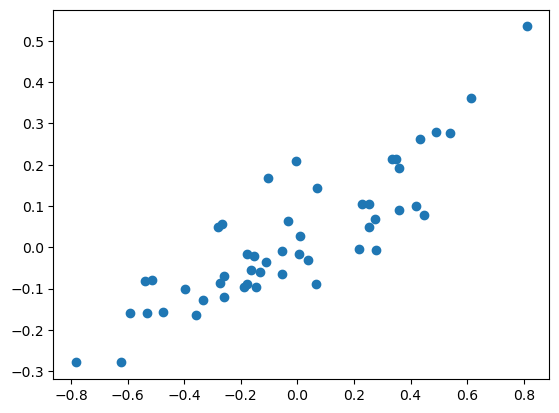

In [8]:
plt.scatter(b21BA,b11BA)

correlation btw $\beta^{p2}_{v1}$ and $\beta^{p2}_{v2}$:  -0.793647435404551


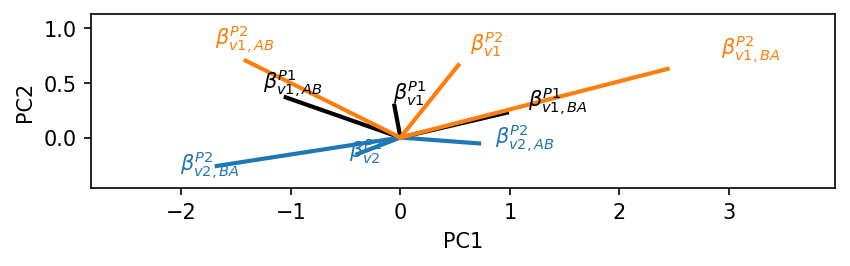

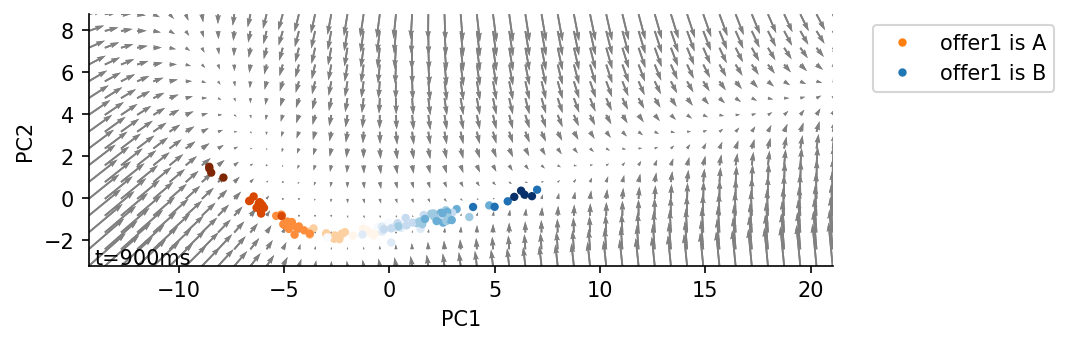

In [11]:
dirPath = './savedForHPC/juiceTaskDefault_20231204-12-12_3_'
# dirPath = './savedForHPC/juiceTaskDefault_20240406-15-04_18_'
# dirPath = './savedForHPC/juiceTaskDefault_20240403-11-04_5_'


(b11,b12,b21,b22),(b11AB,b12AB,b21AB,b22AB),(b11BA,b12BA,b21BA,b22BA),(b11p,b12p,b21p,b22p) = getRegCoeff(dirPath)
c11_21 , c11_22 , c21_22 , c11_21p, c11_22p, c21_22p  = getCorrOfReg(dirPath)
print(r'correlation btw $\beta^{p2}_{v1}$ and $\beta^{p2}_{v2}$: ',c21_22)

def drawVector(ax,vec,vecname,color='k'):
    ax.plot([0,vec[0]],[0,vec[1]],color=color,linewidth=2)
    ax.text(vec[0]*1.2,vec[1]*1.2,vecname,color=color)

    return ax

x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTest.npz')
pcaObj,xlim,ylim,range_x,range_y = getPCA(model_state,xx=0,yy=1)
pcBases = pcaObj.components_[0:2,:].T

fig,ax = plt.subplots(dpi=150)
ax=drawVector(ax,pcBases.T @ b11AB,r'$\beta^{P1}_{v1,AB}$')
ax=drawVector(ax,pcBases.T @ b11BA,r'$\beta^{P1}_{v1,BA}$')
ax=drawVector(ax,pcBases.T @ b11,r'$\beta^{P1}_{v1}$')
ax=drawVector(ax,pcBases.T @ b22AB,r'$\beta^{P2}_{v2,AB}$',color='C0')
ax=drawVector(ax,pcBases.T @ b22BA,r'$\beta^{P2}_{v2,BA}$',color='C0')
ax=drawVector(ax,pcBases.T @ b22,r'$\beta^{P2}_{v2}$',color='C0')
ax=drawVector(ax,pcBases.T @ b21AB,r'$\beta^{P2}_{v1,AB}$',color='C1')
ax=drawVector(ax,pcBases.T @ b21BA,r'$\beta^{P2}_{v1,BA}$',color='C1')
ax=drawVector(ax,pcBases.T @ b21,r'$\beta^{P2}_{v1}$',color='C1')
xmin,xmax,ymin,ymax = ax.axis()
ax.set_xlim(xmin*1.5,xmax*1.5)
ax.set_ylim(ymin*1.5,ymax*1.5)
ax.set_aspect(1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

fig.savefig('./Figure/regressLineDirection/'+dirPath.split('/')[-1]+'.pdf')

fig2 = generateSnapShot_Encoding(dirPath,t=90)
fig2.savefig('./Figure/regressLineDirection/'+dirPath.split('/')[-1]+'.phase1.pdf')
